# Optimisation et Analyse Comparative de Clustering d'Embeddings Textuels
## Feature Engineering

**Objectif :** Ce notebook vise à structurer l'espace latent des descriptions de jeux vidéo (embeddings E5) pour générer des features catégorielles robustes destinées à un modèle prédictif supervisé.

**Méthodologie :**
1.  **Définition des Métriques :** Utilisation d'un score composite (Spécificité/Séparation) et validation par tags utilisateurs.
2.  **Recherche du K optimal :** Approche hybride utilisant l'heuristique du coude (Kneedle) et le critère d'information Bayésien (BIC).
3.  **Benchmark :** Comparaison des approches de réduction de dimension linéaire (PCA) vs topologique (UMAP) couplées au K-means et l'usage de BRETopic

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
!pip install langdetect
from langdetect import detect, LangDetectException

!pip install bertopic
from bertopic import BERTopic


from google.colab import drive
from google.colab import files
import os
# Monter le Drive
drive.mount('/content/drive')
# Changer de répertoire vers SteamAnalyse
project_dir = '/content/drive/MyDrive/SteamAnalyse'
os.chdir(project_dir)

# Configuration pour des graphiques de qualité publication
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# --- LISTE DES STOP-TAGS (Bruit Sémantique) ---
# Justification : Ces tags sont présents dans >25% du corpus ou décrivent
# des aspects techniques (vue, hardware) et non le genre du jeu.
STOP_TAGS = ['Indie', 'Singleplayer', 'Casual', 'Action', 'Adventure', '2D', '3D']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configuration pour des graphiques de qualité publication
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

In [ ]:
# Fonctions Utilitaires & Nettoyage
# --------------------------------------------------------------------------------
# Cette section contient toutes les fonctions de prétraitement et de détection de langue.
# --------------------------------------------------------------------------------# 2. Fonctions Utilitaires & Nettoyage
# --------------------------------------------------------------------------------
# Cette section contient toutes les fonctions de prétraitement et de détection de langue.
# --------------------------------------------------------------------------------
def detect_language_safe(text):
    """
    Fonction auxiliaire pour détecter la langue sans faire planter le script
    si le texte est trop court ou bizarre (ex: symboles uniquement).
    """
    try:
        # On analyse seulement les 100 premiers caractères pour gagner du temps
        return detect(text[:100])
    except LangDetectException:
        return 'unknown'

def read_description(path):
    print("Lecture du fichier...")
    # Lire le fichier JSONL
    df = pd.read_json(path, lines=True)
    len_initial = len(df)

    # ---------------------------------------------------------
    # NIVEAU 1 : Nettoyage technique (Vide et NaN)
    # ---------------------------------------------------------
    df = df[df['description_courte'].notna() & (df['description_courte'].str.strip() != "")]

    # ---------------------------------------------------------
    # NIVEAU 2 : Nettoyage par Métadonnées
    # ---------------------------------------------------------
    if 'type' in df.columns: df = df[df['type'] == 'jeu']
    # ---------------------------------------------------------
    # NIVEAU 3 : Nettoyage Sémantique (Anti-Spam & DLC)
    # ---------------------------------------------------------
    spam_pattern = r"Tiger Tank 59|This DLC contains|requires the base game|soundtrack|artbook|digital art book|DLC|dlc"

    # Suppression des lignes contenant ces motifs
    df = df[~df['description_courte'].str.contains(spam_pattern, case=False, regex=True)]

    # ---------------------------------------------------------
    # NIVEAU 3.5 : Filtre de Langue (Anti-Chinois/Russe/etc.)
    # ---------------------------------------------------------
    print("Filtrage des langues étrangères (cela peut prendre un peu de temps)...")
    # On détecte la langue
    df['lang'] = df['description_courte'].apply(detect_language_safe)

    # On ne garde que l'anglais ('en').
    # Le chinois ('zh-cn'), russe ('ru'), etc. sont supprimés ici.
    df = df[df['lang'] == 'en']

    # ---------------------------------------------------------
    # NIVEAU 4 : Déduplication stricte
    # ---------------------------------------------------------
    df = df.drop_duplicates(subset=['description_courte'])

    # Sélection des colonnes et reset
    cols_to_keep = ['app_id', 'description_courte', 'type','tags_utilisateurs']
    actual_cols = [c for c in cols_to_keep if c in df.columns]
    df = df[actual_cols].reset_index(drop=True)

    # Rapport de nettoyage
    len_final = len(df)
    print(f"--- Rapport de Nettoyage ---")
    print(f"Avant : {len_initial} lignes")
    print(f"Après : {len_final} lignes")
    print(f"Poubelle : {len_initial - len_final} lignes supprimées (Spam, DLC, Doublons, Langues étrangères)")

    return df

## 2. Définition des Métriques d'Évaluation Non-Supervisée

Pour évaluer la pertinence métier des clusters, nous définissons trois métriques basées sur les tags utilisateurs :

1.  **Spécificité Globale ($S_g$) :** Mesure la capacité d'un cluster à capturer des tags sur-représentés par rapport à la moyenne globale.
2.  **Mixing Inter-Cluster ($M_{inter}$) :** Mesure la séparation sémantique (Cosinus) entre les profils de tags des clusters.
3.  **Score Final Ajusté ($S_{adj}$) :** Score composite pénalisant la complexité du modèle (inspiré du BIC).
    $$S_{adj} = \frac{S_g}{M_{inter}} \times \frac{1}{\sqrt{k}}$$

In [ ]:
# ==============================================================================
# SECTION 2 : FONCTIONS D'ÉVALUATION ET DE SCORING
# ==============================================================================
# Cette cellule contient toutes les métriques personnalisées pour évaluer
# la qualité sémantique (Spécificité) et structurelle (Mixing) des clusters.
# ==============================================================================

# ---------------------------------------------------------
# 2. Calcul Rapide du Score (Méthode Vectorisée)
# ---------------------------------------------------------

def top_tags_specifiques(
    df,
    col_tags,
    col_cluster,
    tags_a_exclure=None,
    top_k=3,
    eps=1e-9
):
    """
    Calcule la spécificité des tags pour chaque cluster.
    """
    # 1. Binarisation
    mlb = MultiLabelBinarizer(sparse_output=True)
    tags_matrix = mlb.fit_transform(df[col_tags])

    # 2. Création du DF sparse temporaire
    df_tags = pd.DataFrame.sparse.from_spmatrix(
        tags_matrix,
        columns=mlb.classes_
    )

    # 3. Gestion propre des clusters (conversion en int pour éviter les bugs de catégorie)
    # On utilise .values pour casser le lien avec l'index/type original
    try:
        df_tags['cluster'] = df[col_cluster].astype(int).values
    except:
        # Fallback si ce n'est pas convertible directement (ex: strings)
        df_tags['cluster'] = pd.to_numeric(df[col_cluster], errors='coerce').fillna(-1).astype(int).values

    # 4. Exclusion des Stop-Tags
    if tags_a_exclure:
        if isinstance(tags_a_exclure, str): tags_a_exclure = [tags_a_exclure]
        # On ne supprime que ceux qui existent
        cols_to_drop = [t for t in tags_a_exclure if t in df_tags.columns]
        if cols_to_drop:
            df_tags = df_tags.drop(columns=cols_to_drop)

    # 5. Agrégation
    counts_cluster = df_tags.groupby('cluster').sum()

    # Recalcul des tailles basé sur ce DF nettoyé pour être cohérent
    cluster_sizes = df_tags['cluster'].value_counts().sort_index()

    counts_global = df_tags.drop(columns=['cluster']).sum()
    total_docs = len(df)

    # 6. Probabilités et Lift
    P_t_c = counts_cluster.div(cluster_sizes, axis=0)
    P_t = counts_global / total_docs
    spec_score = P_t_c.div(P_t + eps, axis=1)

    # 7. Extraction
    rows = []
    for cluster_id in spec_score.index:
        # Ignorer le cluster bruit (-1) s'il traîne
        if cluster_id == -1: continue

        top_tags = spec_score.loc[cluster_id].nlargest(top_k)
        for tag, score in top_tags.items():
            rows.append({
                'Cluster': cluster_id,
                'Tag': tag,
                'Score_Specificite': round(score, 3),
                'P_tag_cluster': round(P_t_c.loc[cluster_id, tag], 3),
                'P_tag_global': round(P_t[tag], 3)
            })

    return pd.DataFrame(rows)


def resume_clusters(
    df_top_tags,
    df_original,
    col_cluster_top='Cluster',
    col_cluster_original='cluster',
    k=3
):
    """
    Génère un résumé lisible des clusters.
    Version robuste aux types (int/category/str).
    """
    # 1. Calcul des tailles robuste (Force int)
    try:
        # On travaille sur une copie convertie en int pour s'aligner avec df_top_tags
        s_clusters = df_original[col_cluster_original].astype(int)
        cluster_sizes = s_clusters.value_counts().sort_index()
    except Exception as e:
        print(f"⚠️ Erreur conversion tailles: {e}")
        cluster_sizes = df_original[col_cluster_original].value_counts()

    # 2. Conversion de la colonne Cluster du résumé en int
    df_top = df_top_tags.copy()
    df_top[col_cluster_top] = df_top[col_cluster_top].astype(int)

    rows = []

    # 3. Boucle sécurisée
    for cluster_id in sorted(df_top[col_cluster_top].unique()):
        # Sécurité : Si le cluster n'est pas dans les tailles (ex: filtré), on le saute ou on met 0
        if cluster_id not in cluster_sizes.index:
            taille = 0
        else:
            taille = cluster_sizes.loc[cluster_id]

        subset = (
            df_top[df_top[col_cluster_top] == cluster_id]
            .head(k)
        )

        row = {
            'Cluster': cluster_id,
            'Taille_Cluster': int(taille)
        }

        for i, (_, r) in enumerate(subset.iterrows(), start=1):
            row[f'Tag_{i}'] = r['Tag']
            row[f'Spec_{i}'] = r['Score_Specificite']

        rows.append(row)

    return pd.DataFrame(rows)


def compute_P_t_c(df, col_tags, col_cluster, tags_a_exclure=None):
    mlb = MultiLabelBinarizer(sparse_output=True)
    X = mlb.fit_transform(df[col_tags])
    df_tags = pd.DataFrame.sparse.from_spmatrix(X, columns=mlb.classes_)

    # Conversion robuste en int
    try:
        df_tags['cluster'] = df[col_cluster].astype(int).values
    except:
        df_tags['cluster'] = pd.to_numeric(df[col_cluster], errors='coerce').fillna(-1).astype(int).values

    if tags_a_exclure:
        if isinstance(tags_a_exclure, str): tags_a_exclure = [tags_a_exclure]
        cols_to_drop = [t for t in tags_a_exclure if t in df_tags.columns]
        if cols_to_drop:
            df_tags = df_tags.drop(columns=cols_to_drop)

    counts_cluster = df_tags.groupby('cluster').sum()
    cluster_sizes = df_tags['cluster'].value_counts().sort_index()

    # Sécurité division par zéro
    cluster_sizes = cluster_sizes.replace(0, 1)

    P_t_c = counts_cluster.div(cluster_sizes, axis=0)
    return P_t_c


def score_par_cluster(df_top_tags, col_cluster='Cluster', col_score='Score_Specificite', k=3):
    rows = []
    for cluster_id in df_top_tags[col_cluster].unique():
        top_k = (
            df_top_tags[df_top_tags[col_cluster] == cluster_id]
            .sort_values(col_score, ascending=False)
            .head(k)
        )
        score_cluster = top_k[col_score].mean()
        rows.append({
            'Cluster': cluster_id,
            'Score_Cluster': round(score_cluster, 3)
        })
    return pd.DataFrame(rows)


def score_global_clustering(df, df_cluster_scores, col_cluster='cluster'):
    # Conversion robuste pour le mapping
    s_cluster = df[col_cluster].astype(int)
    cluster_sizes = s_cluster.value_counts()

    df_score = df_cluster_scores.copy()
    df_score['Cluster'] = df_score['Cluster'].astype(int)

    # Map des tailles
    df_score['Taille_Cluster'] = df_score['Cluster'].map(cluster_sizes).fillna(0)

    total_taille = df_score['Taille_Cluster'].sum()
    if total_taille == 0:
        return 0, df_score

    score_global = (
        (df_score['Score_Cluster'] * df_score['Taille_Cluster']).sum()
        / total_taille
    )
    return round(score_global, 3), df_score


def score_clustering_complet(score_specificite, P_t_c, eps=1e-9):
    # Mixing
    M = P_t_c.values
    if M.shape[0] > 1:
        S = cosine_similarity(M)
        K = S.shape[0]
        mixing = S[np.triu_indices(K, k=1)].mean()
    else:
        mixing = 0.0 # Cas d'un seul cluster

    mixing = round(mixing, 4)
    score_final = score_specificite / (mixing + eps)

    return {
        "Specificite_Globale": score_specificite,
        "Mixing_InterClusters": mixing,
        "Score_Final": round(score_final, 3)
    }

def evaluation_complete_clustering(df, col_tags, col_cluster, stop_tags, X_data=None, top_k=3, nb_lignes_markdown=10, verbose=True):
    """
    Fonction wrapper qui lance tout le pipeline d'évaluation.

    Args:
        df: DataFrame contenant les données et les clusters.
        col_tags: Colonne des tags.
        col_cluster: Colonne des labels de cluster.
        stop_tags: Liste des tags à exclure.
        X_data: (Optionnel) Array numpy des embeddings (X_reduced, X_umap, etc.) pour calculer le BIC.
    """
    # 1. Calculs des tops tags et scores
    df_scores = top_tags_specifiques(df, col_tags, col_cluster, tags_a_exclure=stop_tags, top_k=top_k)

    # 2. Résumé lisible
    df_resume = resume_clusters(df_scores, df, col_cluster_original=col_cluster)

    if verbose:
        print(f"--- Aperçu des {nb_lignes_markdown} premiers clusters ---")
        print(df_resume.head(nb_lignes_markdown).to_markdown(index=False))

    # 3. Score Global Spécificité
    df_cluster_scores = score_par_cluster(df_scores, k=top_k)
    score_spec, _ = score_global_clustering(df, df_cluster_scores, col_cluster=col_cluster)

    # 4. Score Mixing & Final
    P_t_c = compute_P_t_c(df, col_tags, col_cluster, tags_a_exclure=stop_tags)
    resultats_complets = score_clustering_complet(score_spec, P_t_c)

    # 5. Calcul du BIC (Nouveau Bloc)
    if X_data is not None:
        # Vérification d'alignement
        if len(X_data) != len(df):
            print(f"⚠️ Attention : La taille de X ({len(X_data)}) ne correspond pas au DataFrame ({len(df)}). Calcul du BIC ignoré.")
        else:
            labels = df[col_cluster].values
            unique_labels = np.unique(labels)
            n_samples = len(X_data)

            # On ignore le cluster de bruit (-1) pour le comptage des paramètres k
            n_clusters_k = len(unique_labels) - (1 if -1 in unique_labels else 0)

            # Calcul manuel de l'inertie (Somme des distances au carré au centroïde)
            inertia = 0
            for k in unique_labels:
                if k == -1: continue # Le bruit n'a pas de centroïde

                mask = (labels == k)
                points = X_data[mask]

                if len(points) > 0:
                    center = points.mean(axis=0)
                    # Distances euclidiennes au carré
                    inertia += np.sum((points - center)**2)

            # Formule du BIC : n * ln(MSE) + k * ln(n)
            # MSE = inertia / n
            if inertia > 0:
                mse = inertia / n_samples
                bic = n_samples * np.log(mse) + n_clusters_k * np.log(n_samples)

                resultats_complets['BIC'] = round(bic, 2)
                resultats_complets['Inertia'] = round(inertia, 2)

    if verbose:
        print("\n=== RÉSULTATS GLOBAUX ===")
        for k, v in resultats_complets.items():
            print(f"{k} : {v}")

    return resultats_complets

def clean_cluster_column(df, col_cluster):
    df = df.copy()
    df[col_cluster] = (
        df[col_cluster]
        .astype(str)
        .str.extract(r'^(-?\d+)')  # récupère seulement l'entier
        .astype(int)
    )
    return df


def score_mixing_inter_clusters(P_t_c):
    # matrice clusters × tags
    M = P_t_c.values

    # similarité cosinus
    S = cosine_similarity(M)

    # garder seulement les paires i < j
    K = S.shape[0]
    # np.triu_indices avec k=1 exclut la diagonale
    mixing = S[np.triu_indices(K, k=1)].mean()

    return round(mixing, 4)


def optimize_k_pca(X_reduced, df, col_tags='tags_utilisateurs',
                             k_min=10, k_max=400, k_step=10, top_k_tags=3, variance_ratio=0.9,
                             tags_a_exclure=None,title="title"):
    """
    Test plusieurs k pour KMeans, calcule Specificité, Mixing, Score_Final ET BIC.
    Affiche deux plots : vos métriques custom et le BIC.
    """
    n_samples, _ = X_reduced.shape
    results = []

    print(f"--- Lancement du test de k={k_min} à k={k_max} ---")
    for k in range(k_min, k_max+1, k_step):
        # 2. Clustering
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_reduced)
        df['cluster'] = labels

        # --- CALCUL DU BIC ---
        # Formule approximée pour K-Means : n * ln(MSE) + k * ln(n)
        # MSE = inertia / n
        inertia = kmeans.inertia_
        mse = inertia / n_samples
        bic = n_samples * np.log(mse) + k * np.log(n_samples)

        # 3. Top tags spécifiques (Vos métriques)
        # On utilise votre fonction existante (assurez-vous qu'elle est chargée)
        df_scores = top_tags_specifiques(df, col_tags, 'cluster', top_k=top_k_tags, tags_a_exclure=tags_a_exclure)
        df_cluster_scores = score_par_cluster(df_scores, k=top_k_tags)
        score_global, _ = score_global_clustering(df, df_cluster_scores, col_cluster='cluster')

        # 4. Calcul P(tag|cluster) et score final
        P_t_c = compute_P_t_c(df, col_tags=col_tags, col_cluster='cluster', tags_a_exclure=tags_a_exclure)
        scores = score_clustering_complet(score_global, P_t_c)

        # Sauvegarde
        results.append({
            'k': k,
            'Specificite': scores['Specificite_Globale'],
            'Mixing': scores['Mixing_InterClusters'],
            # Score pénalisé par racine carrée comme validé précédemment
            'Score_Final_Ajuste': scores['Score_Final'] / np.sqrt(k),
            'BIC': bic,
            'Inertia': inertia
        })
        if ((k-k_min) % (50)) == 0: print(f"Traitement k={k} terminé...")

    df_results = pd.DataFrame(results)

    # --- PLOT 1 : Vos Métriques Custom ---
    plt.figure(figsize=(12, 10))

    plt.subplot(2, 1, 1)
    ax1 = plt.gca()
    l1 = ax1.plot(df_results['k'], df_results['Specificite'], label='Specificité Globale', color='blue')
    l2 = ax1.plot(df_results['k'], df_results['Score_Final_Ajuste'], label='Score Final Ajusté (sqrt(k))', color='green', linewidth=2)
    ax1.set_xlabel('Nombre de clusters (k)')
    ax1.set_ylabel('Score Qualité')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    l3 = ax2.plot(df_results['k'], df_results['Mixing'], label='Mixing Inter-Clusters', color='red', linestyle='--')
    ax2.set_ylabel('Mixing (Plus bas est mieux)')
    ax2.set_ylim(0, 1)

    # Légende combinée
    lns = l1 + l2 + l3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='center right')
    plt.title(f'Métriques Sémantiques & Structurelles')

    # --- PLOT 2 : BIC (Critère Mathématique) ---
    plt.subplot(2, 1, 2)
    plt.plot(df_results['k'], df_results['BIC'], label='BIC Score', color='purple', marker='o', markersize=4)
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('BIC (Plus bas est mieux)')
    plt.title('Critère BIC (Bayesian Information Criterion)')
    plt.grid(True, alpha=0.3)

    # Détection visuelle du minimum ou du coude sur le BIC
    min_bic_idx = df_results['BIC'].idxmin()
    best_k_bic = df_results.loc[min_bic_idx, 'k']
    plt.axvline(best_k_bic, color='black', linestyle=':', label=f'Min BIC (k={best_k_bic})')
    plt.legend()

    plt.tight_layout()
    plt.savefig(title)
    plt.show()

    return df_result

In [ ]:
df = pd.read_parquet("embedding.parquet")
df_all = read_description("valide_data.jsonl")
df = pd.merge(df, df_all, on="app_id")
X = df[df["type"]=="jeu"].drop(columns=['app_id','description_courte',"type",'tags_utilisateurs'])
X.head()

Lecture du fichier...
Filtrage des langues étrangères (cela peut prendre un peu de temps)...
--- Rapport de Nettoyage ---
Avant : 81190 lignes
Après : 59313 lignes
Poubelle : 21877 lignes supprimées (Spam, DLC, Doublons, Langues étrangères)


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,-0.015515,-0.040634,-0.039410,-0.024553,0.060766,-0.016784,0.003307,0.029646,-0.020718,-0.040895,...,0.001481,-0.006138,0.037936,-0.041931,0.034727,0.015080,-0.059394,-0.028341,0.042910,0.025245
1,0.010040,-0.048632,-0.039975,-0.014079,0.054651,-0.001169,0.083036,0.043449,-0.053732,-0.004614,...,0.045610,-0.057862,0.041564,-0.037886,0.048668,0.017024,-0.078608,0.004969,0.013197,0.040402
2,-0.059601,-0.053385,-0.044010,0.031389,0.063745,-0.049218,-0.008127,0.061023,-0.029774,-0.017229,...,0.021553,-0.021234,0.050738,-0.035896,0.035286,-0.000186,-0.039050,-0.022452,0.028244,0.062222
3,-0.021737,-0.057124,-0.024447,-0.019569,0.066276,-0.078666,0.018553,0.081685,-0.038769,-0.040664,...,-0.000309,-0.028253,0.047141,-0.054390,0.004867,0.015500,-0.027166,-0.023444,-0.003940,0.035559
4,0.013848,-0.052353,-0.038737,0.016317,0.024169,-0.050124,0.024922,0.053515,0.001757,0.000299,...,0.023023,-0.043919,0.044560,-0.028018,0.039583,0.023074,-0.027708,-0.011105,0.050956,0.059836


In [ ]:
# 1. On rassemble tous les tags dans une seule liste
# (On suppose que ta colonne 'tags' contient des listes de chaînes ou des chaînes séparées par virgule)
all_tags = []

for tags in df['tags_utilisateurs']:
    # Si c'est une liste :
    if isinstance(tags, list):
        all_tags.extend(tags)
    # Si c'est une string "Action, Indie, Adventure" :
    elif isinstance(tags, str):
        all_tags.extend([t.strip() for t in tags.split(',')])

# 2. On compte
tag_counts = Counter(all_tags)

# 3. On affiche les 20 plus fréquents avec leur % d'apparition
total_games = len(df)
print(f"{'Tag':<20} | {'Count':<10} | {'% Games'}")
print("-" * 45)
for tag, count in tag_counts.most_common(20):
    percent = (count / total_games) * 100
    print(f"{tag:<20} | {count:<10} | {percent:.1f}%")

Tag                  | Count      | % Games
---------------------------------------------
Indie                | 58942      | 99.4%
Singleplayer         | 42087      | 71.0%
Casual               | 27943      | 47.1%
Action               | 26732      | 45.1%
Adventure            | 26037      | 43.9%
2D                   | 21142      | 35.6%
3D                   | 13920      | 23.5%
Puzzle               | 12476      | 21.0%
Simulation           | 12320      | 20.8%
Strategy             | 12278      | 20.7%
Atmospheric          | 11931      | 20.1%
Pixel Graphics       | 11179      | 18.8%
RPG                  | 10413      | 17.6%
Colorful             | 9785       | 16.5%
Exploration          | 9531       | 16.1%
Story Rich           | 9339       | 15.7%
Cute                 | 9177       | 15.5%
First-Person         | 8941       | 15.1%
Fantasy              | 8070       | 13.6%
Arcade               | 7926       | 13.4%


In [ ]:
# --- LISTE DES STOP-TAGS (Bruit Sémantique) ---
# Justification : Ces tags sont présents dans >25% du corpus ou décrivent
# des aspects techniques (vue) et non le genre du jeu.
STOP_TAGS = ['Indie', 'Singleplayer', 'Casual', 'Action', 'Adventure', '2D', '3D']

In [ ]:
print("Réduction de dimension (PCA)...")

pca_full = PCA()
pca_full.fit(X)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.searchsorted(cumulative_variance, 0.95) + 1
n_components_90 = np.searchsorted(cumulative_variance, 0.90) + 1

print("Dimensions nécessaires pour 95% de variance :", n_components_95)
print("Dimensions nécessaires pour 90% de variance :", n_components_90)

pca = PCA(n_components=n_components_95)
embeddings_reduced = pca.fit_transform(X)

pca = PCA(n_components=n_components_90)
embeddings_reduced90 = pca.fit_transform(X)

print("Nouvelle shape :", embeddings_reduced.shape)

print("Réduction UMAP (Mode Densité Maximale)...")
umap_model = UMAP(
    n_components=5,
    n_neighbors=60,       #  réduire le bruit avec E5.
    min_dist=0.0,         #  est déjà précis, on veut tasser les groupes.
    metric='cosine',
    random_state=42
)
X_umap = umap_model.fit_transform(X)


Réduction de dimension (PCA)...
Dimensions nécessaires pour 95% de variance : 406
Dimensions nécessaires pour 90% de variance : 323
Nouvelle shape : (59313, 406)
Réduction UMAP (Mode Densité Maximale)...


## 3. Optimisation du nombre de clusters ($k$)

Nous procédons à une analyse de sensibilité sur l'intervalle $k \in [10, 400]$.
Deux critères sont confrontés :
1.  **Critère BIC (Bayesian Information Criterion) :** Mesure l'adéquation aux données pénalisée par le nombre de paramètres. On cherche le minimum.
2.  **Score Sémantique Ajusté :** Métrique métier. On cherche le point de saturation (coude).

--- Lancement du test de k=10 à k=310 ---
Traitement k=10 terminé...
Traitement k=160 terminé...
Traitement k=310 terminé...


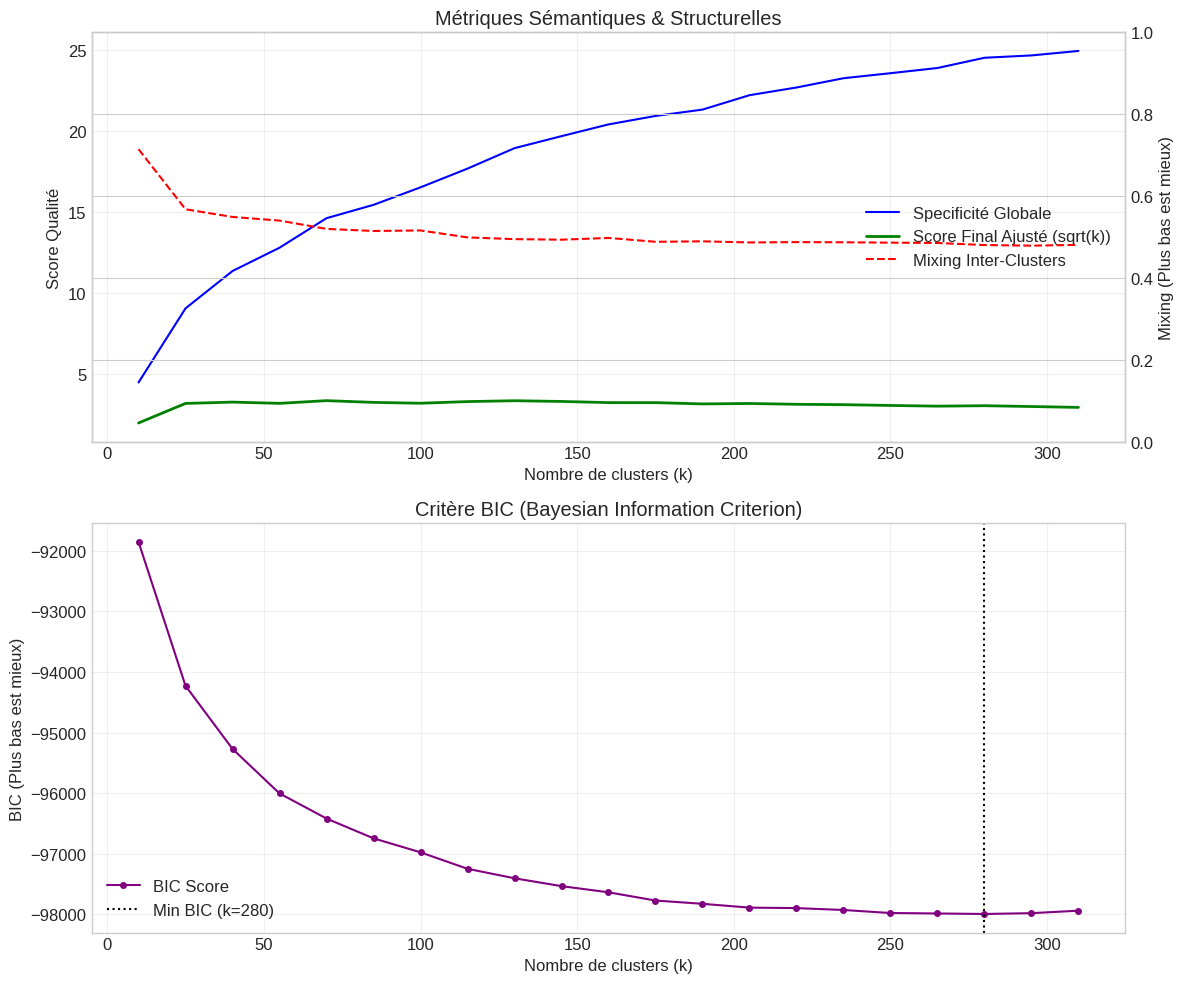

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_scores_k = optimize_k_pca(embeddings_reduced, df, k_min=10, k_max=310, k_step=15, top_k_tags=3, variance_ratio=0.95, tags_a_exclure=STOP_TAGS)
files.download("K-means_Analysis_BIC.pdf")

--- Lancement du test de k=100 à k=225 ---
Traitement k=100 terminé...
Traitement k=150 terminé...
Traitement k=200 terminé...


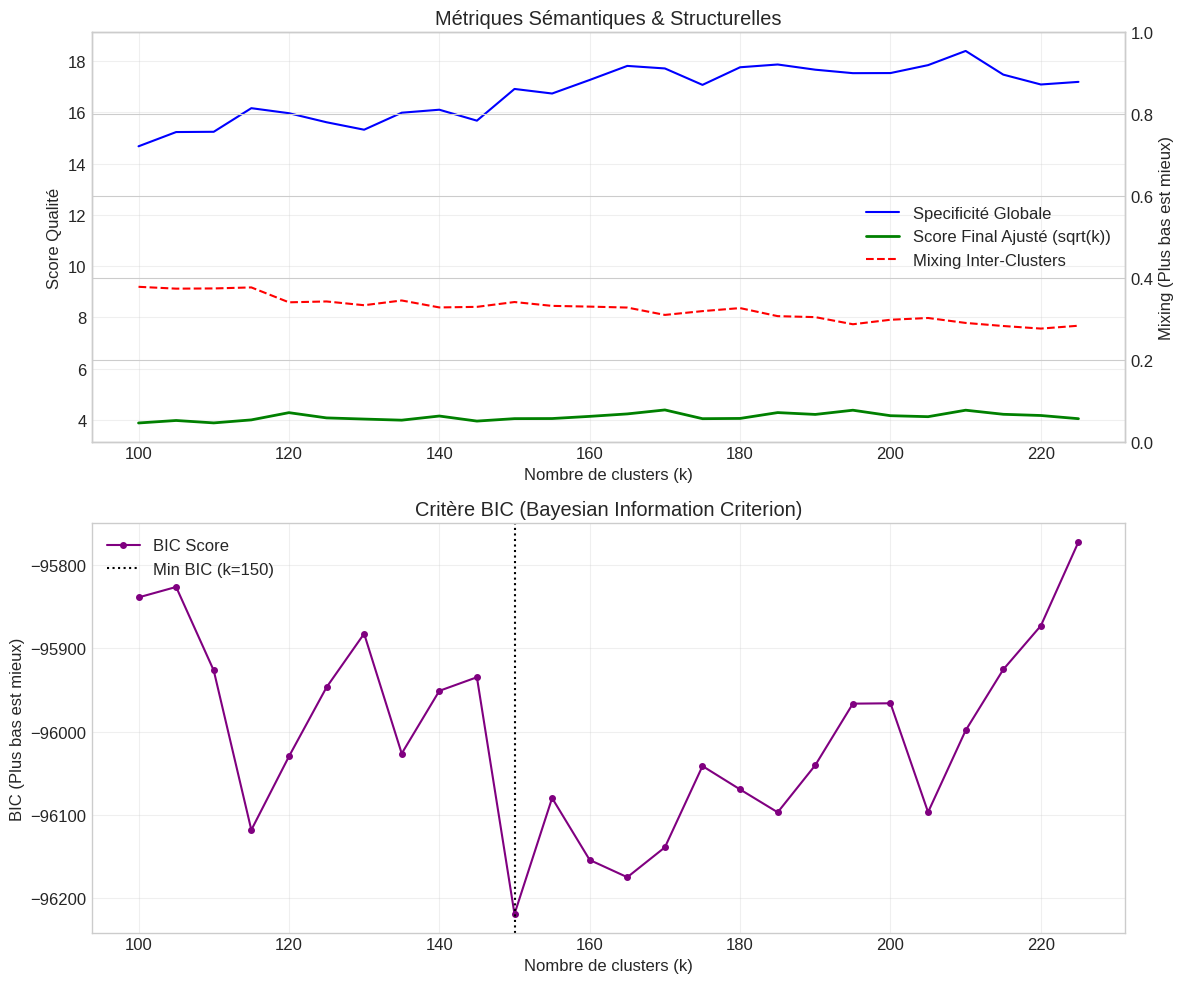

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_scores_k = optimize_k_pca(embeddings_reduced, df, k_min=100, k_max=225, k_step=5, top_k_tags=3, variance_ratio=0.95, tags_a_exclure=STOP_TAGS)
files.download("K-means_Analysis_BIC.pdf")

--- Lancement du test de k=10 à k=410 ---
Traitement k=10 terminé...
Traitement k=60 terminé...
Traitement k=110 terminé...
Traitement k=160 terminé...
Traitement k=210 terminé...
Traitement k=260 terminé...
Traitement k=310 terminé...
Traitement k=360 terminé...
Traitement k=410 terminé...


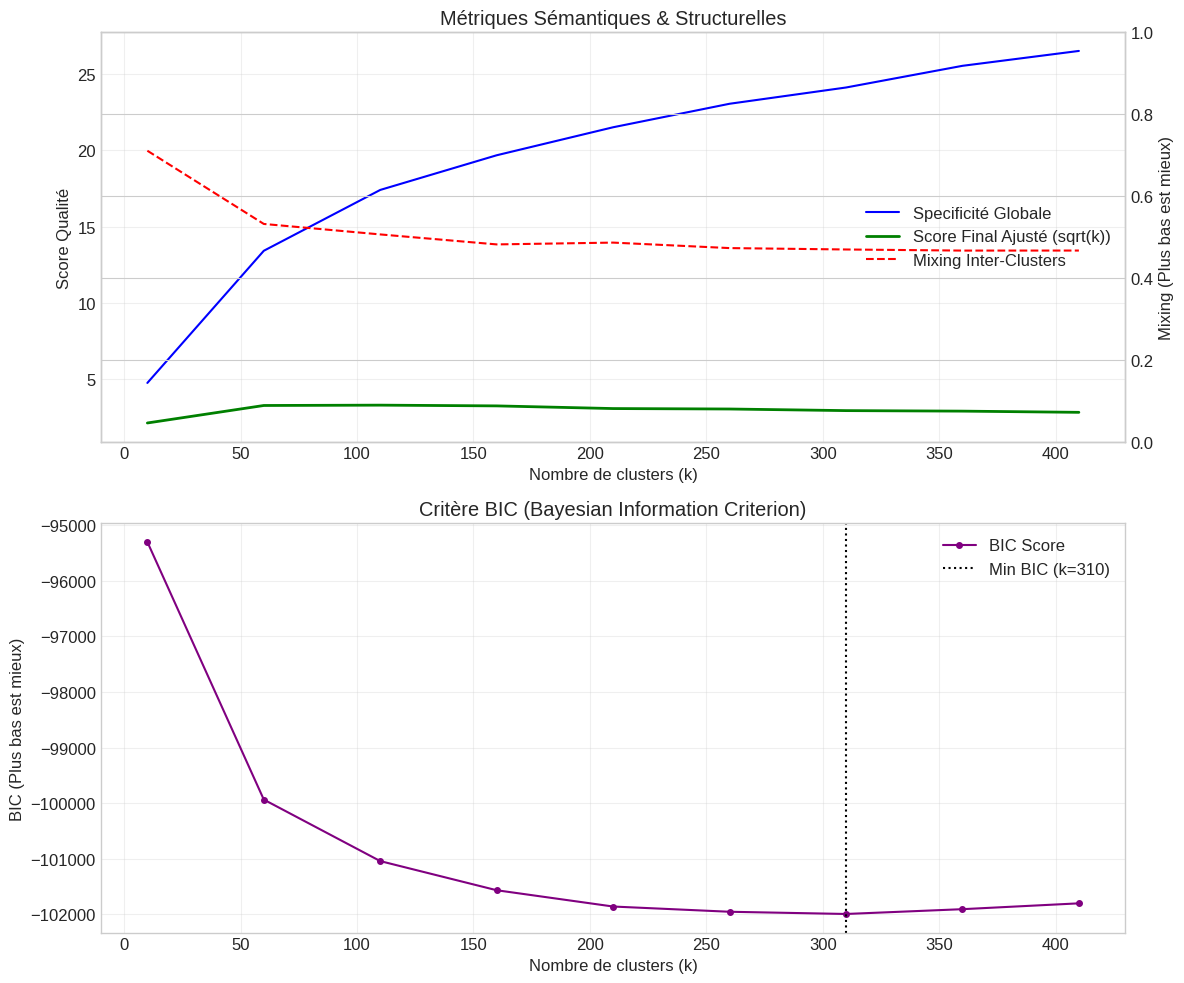

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
title="K-means_Analysis_BIC_PCA90.pdf"
df_scores_k = optimize_k_pca(embeddings_reduced90, df, k_min=10, k_max=410, k_step=50, top_k_tags=3, variance_ratio=0.90, tags_a_exclure=STOP_TAGS,title=title)
files.download(title)

--- Lancement du test de k=10 à k=310 ---
Traitement k=10 terminé...
Traitement k=160 terminé...
Traitement k=310 terminé...


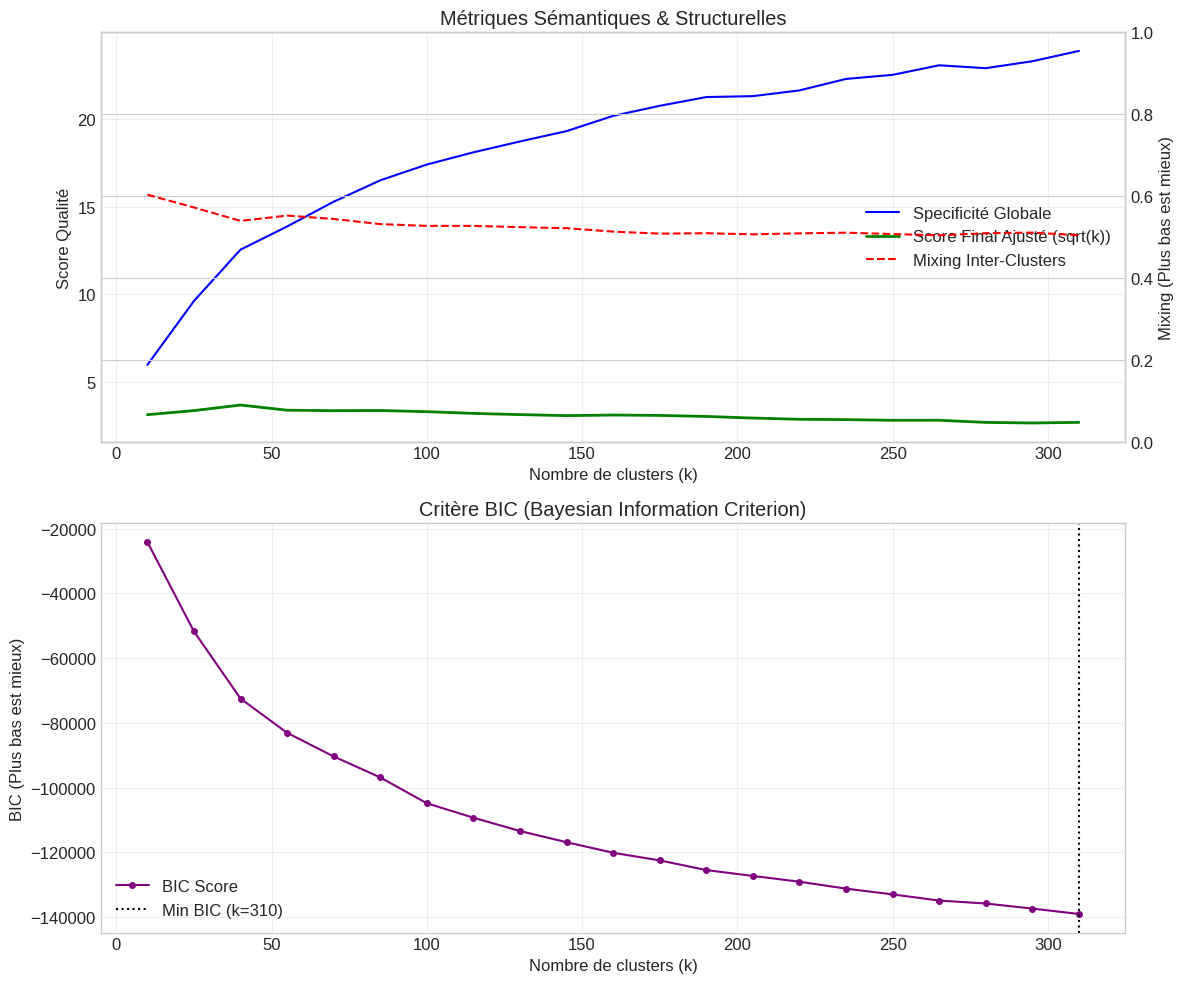

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
title="K-means_Analysis_BIC_UMAP.pdf"
df_scores_k = optimize_k_pca(X_umap, df, k_min=10, k_max=310, k_step=15, top_k_tags=3, variance_ratio=0.95, tags_a_exclure=STOP_TAGS,title=title)
files.download(title)

## 4. Benchmark Final : Structure vs Sémantique

À $k=175$ (optimum BIC), nous comparons deux pipelines de vectorisation/clustering :

1.  **Baseline Structurelle :** Embeddings $\rightarrow$ PCA (linéaire) $\rightarrow$ K-means.
2.  **Approche Sémantique (BERTopic) :** Embeddings $\rightarrow$ UMAP (non-linéaire) $\rightarrow$ K-means.
3. **Approche Sémantique (BERTopic) :** Embeddings $\rightarrow$ UMAP (non-linéaire) $\rightarrow$ HDBSCAN.


L'objectif est de déterminer si la conservation de la topologie locale (UMAP) apporte un gain de pureté sémantique significatif par rapport à la variance globale (PCA).

In [ ]:

K_FINAL = 280
cluster_name = 'cluster_KPCA'
kmeans_pca = KMeans(n_clusters=K_FINAL, random_state=42, n_init='auto')
df[cluster_name] = kmeans_pca.fit_predict(embeddings_reduced)
score_KPCA = evaluation_complete_clustering( df,
    col_tags='tags_utilisateurs',
    col_cluster=cluster_name,
    stop_tags=STOP_TAGS,
    X_data=embeddings_reduced,
    top_k=3,
    nb_lignes_markdown=10,
    verbose=True)

--- Aperçu des 10 premiers clusters ---
|   Cluster |   Taille_Cluster | Tag_1          |   Spec_1 | Tag_2                 |   Spec_2 | Tag_3              |   Spec_3 |
|----------:|-----------------:|:---------------|---------:|:----------------------|---------:|:-------------------|---------:|
|         0 |              138 | Farming        |  103.286 | Agriculture           |   66.503 | Farming Sim        |   65.893 |
|         1 |              344 | Unforgiving    |   18.836 | Precision Platformer  |   14.447 | Parkour            |    8.723 |
|         2 |              125 | Web Publishing |   32.724 | Design & Illustration |   17.991 | Photo Editing      |   14.379 |
|         3 |              249 | Fox            |    8.822 | 360 Video             |    7.006 | Wrestling          |    6.806 |
|         4 |              210 | Fox            |   20.922 | Based On A Novel      |   10.461 | Jump Scare         |    8.07  |
|         5 |              207 | Skiing         |   27.729 | Bas

In [ ]:

K_FINAL = 310
cluster_name = 'cluster_KPCA90'
kmeans_pca = KMeans(n_clusters=K_FINAL, random_state=42)
df[cluster_name] = kmeans_pca.fit_predict(embeddings_reduced90)
score_KPCA = evaluation_complete_clustering( df,
    col_tags='tags_utilisateurs',
    col_cluster=cluster_name,
    stop_tags=STOP_TAGS,
    X_data=embeddings_reduced90,
    top_k=3,
    nb_lignes_markdown=10,
    verbose=True)

--- Aperçu des 10 premiers clusters ---
|   Cluster |   Taille_Cluster | Tag_1                             |   Spec_1 | Tag_2                          |   Spec_2 | Tag_3        |   Spec_3 |
|----------:|-----------------:|:----------------------------------|---------:|:-------------------------------|---------:|:-------------|---------:|
|         0 |              234 | Open World Survival Craft         |   37.95  | Hunting                        |   21.123 | Dinosaurs    |   12.365 |
|         1 |              238 | TrackIR                           |   27.69  | BMX                            |   23.735 | Remake       |   22.656 |
|         2 |              119 | Social Deduction                  |   23.455 | FMV                            |   18.988 | Movie        |   17.801 |
|         3 |              167 | Documentary                       |   73.993 | Feature Film                   |   71.033 | 360 Video    |   62.677 |
|         4 |              118 | Match 3                    

In [ ]:
data=np.array(X)
cluster_name='cluster_BERTopic_K'
cluster_model = KMeans(n_clusters=K_FINAL, random_state=42, n_init='auto')
topic_model = BERTopic(embedding_model=None, hdbscan_model=cluster_model)
topics, _ = topic_model.fit_transform(df['description_courte'], data)
topic_info = topic_model.get_topic_info()
df[cluster_name] = topics

score_KPCA = evaluation_complete_clustering( df,
    col_tags='tags_utilisateurs',
    col_cluster=cluster_name,
    stop_tags=STOP_TAGS,
    X_data=data,
    top_k=3,
    nb_lignes_markdown=10,
    verbose=True)

--- Aperçu des 10 premiers clusters ---
|   Cluster |   Taille_Cluster | Tag_1                 |   Spec_1 | Tag_2                |   Spec_2 | Tag_3              |   Spec_3 |
|----------:|-----------------:|:----------------------|---------:|:---------------------|---------:|:-------------------|---------:|
|         0 |             1188 | Jump Scare            |   10.936 | Thriller             |    8.127 | Survival Horror    |    7.881 |
|         1 |              971 | Otome                 |   24.746 | Romance              |   16.369 | Visual Novel       |   15.409 |
|         2 |              865 | Ninja                 |   11.723 | Elf                  |    8.571 | Platformer         |    6.274 |
|         3 |              785 | Unforgiving           |   12.064 | Precision Platformer |   11.922 | Parkour            |    9.109 |
|         4 |              782 | MMORPG                |   13.753 | Party-Based RPG      |   13.378 | JRPG               |   10.881 |
|         5 |         

In [ ]:
cluster_name='cluster_BERTopic_K135'
cluster_model = KMeans(n_clusters=300, random_state=42, n_init='auto')
topic_model = BERTopic(embedding_model=None, hdbscan_model=cluster_model)
topics, _ = topic_model.fit_transform(df['description_courte'], data)
topic_info = topic_model.get_topic_info()
df[cluster_name] = topics

score_KPCA = evaluation_complete_clustering( df,
    col_tags='tags_utilisateurs',
    col_cluster=cluster_name,
    stop_tags=STOP_TAGS,
    X_data=data,
    top_k=3,
    nb_lignes_markdown=10,
    verbose=True)

--- Aperçu des 10 premiers clusters ---
|   Cluster |   Taille_Cluster | Tag_1                 |   Spec_1 | Tag_2                             |   Spec_2 | Tag_3              |   Spec_3 |
|----------:|-----------------:|:----------------------|---------:|:----------------------------------|---------:|:-------------------|---------:|
|         0 |              983 | Otome                 |   23.563 | Romance                           |   16.64  | Visual Novel       |   15.492 |
|         1 |              673 | Jump Scare            |   10.072 | Thriller                          |    9.14  | Survival Horror    |    8.205 |
|         2 |              623 | Tower Defense         |   34.105 | Real Time Tactics                 |   12.274 | Action RTS         |   11.901 |
|         3 |              596 | Precision Platformer  |   11.695 | Unforgiving                       |    9.199 | Parkour            |    6.749 |
|         4 |              594 | Audio Production      |   58.248 | Music-Base

In [ ]:
cluster_name='cluster_BERTopic'
topic_model = BERTopic(embedding_model=None)

# Use the original df['description_courte'] and X for fit_transform
# The topics variable will hold the topic assignments for the original, unfiltered DataFrame
original_topics, _ = topic_model.fit_transform(df['description_courte'], data)

# Store initial topics in the DataFrame
df[cluster_name] = original_topics

# NOTE: The problematic line `df = df[df[cluster_name] != -1].copy()` was removed here.
# This ensures that df['description_courte'] and X.to_numpy() are still aligned with original_topics.

# Reduce outliers using the original documents, original topics, and original embeddings
new_topics = topic_model.reduce_outliers(
    documents=df['description_courte'],  # Use unfiltered documents
    topics=original_topics,             # Use original topics output from fit_transform
    strategy="embeddings",
    embeddings=X.to_numpy()             # Use original embeddings
)

# Update the topic model with the new topics (outliers are now re-assigned or kept as -1 based on strategy)
topic_model.update_topics(df['description_courte'], topics=new_topics)

# Update your DataFrame with the new topics from the model
df[cluster_name] = topic_model.topics_

# 4. Vérification : Est-ce qu'il reste du bruit ?
bruit_restant = (df[cluster_name] == -1).sum()
print(f"Points restants dans le bruit : {bruit_restant} (sur {len(df)})\n")

score_KPCA = evaluation_complete_clustering( df,
    col_tags='tags_utilisateurs',
    col_cluster=cluster_name,
    stop_tags=STOP_TAGS,
    top_k=3,
    X_data=data,
    nb_lignes_markdown=10,
    verbose=True)

2025-12-14 15:05:44,124 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


Points restants dans le bruit : 0 (sur 59313)

--- Aperçu des 10 premiers clusters ---
|   Cluster |   Taille_Cluster | Tag_1                             |   Spec_1 | Tag_2             |   Spec_2 | Tag_3            |   Spec_3 |
|----------:|-----------------:|:----------------------------------|---------:|:------------------|---------:|:-----------------|---------:|
|         0 |             2900 | Precision Platformer              |    8.513 | Unforgiving       |    6.875 | Parkour          |    6.561 |
|         1 |             1333 | Otome                             |   22.735 | Romance           |   16.165 | Dating Sim       |   14.582 |
|         2 |             1048 | ATV                               |   45.277 | BMX               |   43.121 | Motocross        |   40.426 |
|         3 |             1444 | Party-Based RPG                   |   12.222 | MMORPG            |    9.93  | JRPG             |    9.59  |
|         4 |             1574 | Jump Scare                        

In [ ]:
# ==============================================================================
# 5. VISUALISATION DES RÉSULTATS
# ==============================================================================
print("Génération de la carte des topics...")

# 1. Visualisation Inter-topic (Distance map)
# Montre quels sujets sont proches (ex: RPG proche de Fantasy)
fig1 = topic_model.visualize_topics()
fig1.show()

# 2. Visualisation des Documents (Projection 2D)
# C'est la "carte du ciel" de tes jeux.
# Note : On utilise un échantillon si le dataset est trop gros pour éviter que le navigateur ne crash
fig2 = topic_model.visualize_documents(
    df['description_courte'],
    embeddings=X.to_numpy(), # Tes embeddings E5
    hide_annotations=True,
    hide_document_hover=False,
    custom_labels=True
)
fig2.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Fusionner pour tomber à 150 topics (si 311 est trop lourd)
# Attention : À faire APRES avoir tout fini, juste pour voir.
topic_model.reduce_topics(df['description_courte'], nr_topics=150)

# Maintenant, visualisez : la carte sera plus aérée
topic_model.visualize_topics()

In [ ]:
# ==============================================================================
# 6. ANALYSE HIÉRARCHIQUE
# ==============================================================================
# Permet de voir les "Super-Catégories" (ex: FPS et TPS regroupés dans "Shooters")

fig_hierarchy = topic_model.visualize_hierarchy(top_n_topics=50)
fig_hierarchy.show()

In [ ]:
# ==============================================================================
# 7. FEATURE ENGINEERING & EXPORT
# ==============================================================================

# 1. Récupération des noms de topics
topic_info = topic_model.get_topic_info()
# On crée un dictionnaire {id_topic: "nom_propre_du_topic"}
# On nettoie le nom pour enlever le "0_" au début
topic_mapping = {
    row['Topic']: "_".join(row['Name'].split('_')[1:])
    for _, row in topic_info.iterrows()
}

# 2. Application au DataFrame
df_final = df.copy()
df_final['cluster_id'] = df_final[cluster_name]                      # Garde l'ID numérique (pour XGBoost/LGBM)
df_final['cluster_name'] = df_final['cluster_id'].map(topic_mapping) # Garde le nom (pour l'analyse)

# 3. Aperçu des nouvelles features
print("Exemple de features générées :")
print(df_final[['cluster_id', 'cluster_name']].head())

# 4. Sauvegarde
df_final.to_parquet("steam_data_clustered.parquet")
print("✅ Données sauvegardées avec les clusters BERTopic (Bruit réassigné).")

Exemple de features générées :
   cluster_id                          cluster_name
0          45  survivors_survivor_roguelite_survive
1          76                  coffee_caf_cafe_shop
2          16              planet_space_alien_earth
3          50                  job_night_shift_work
4          14            space_shooter_arcade_alien
✅ Données sauvegardées avec les clusters BERTopic (Bruit réassigné).
